In [16]:
from google.colab import files
uploaded = files.upload()


Saving netflix_titles.csv to netflix_titles (1).csv


In [17]:
import pandas as pd

df = pd.read_csv('netflix_titles.csv')
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [18]:
df['title_id'] = df.index + 1  # simple primary key


In [19]:
genre_rows = []

for _, row in df.iterrows():
    genres = str(row['listed_in']).split(', ')
    for genre in genres:
        genre_rows.append({'title_id': row['title_id'], 'genre': genre})

genre_df = pd.DataFrame(genre_rows)
genre_df.head()


,title_id,genre
0,1,Documentaries
1,2,International TV Shows
2,2,TV Dramas
3,2,TV Mysteries
4,3,Crime TV Shows


In [20]:
genre_list = genre_df['genre'].drop_duplicates().reset_index(drop=True).reset_index()
genre_list.columns = ['genre_id', 'genre']
genre_list['genre_id'] += 1  # start from 1

genre_list.head()


,genre_id,genre
0,1,Documentaries
1,2,International TV Shows
2,3,TV Dramas
3,4,TV Mysteries
4,5,Crime TV Shows


In [21]:
# Merge genre_df with genre_list to get genre_id
title_genre_df = genre_df.merge(genre_list, on='genre', how='left')[['title_id', 'genre_id']]
title_genre_df.head()


,title_id,genre_id
0,1,1
1,2,2
2,2,3
3,2,4
4,3,5


In [22]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///netflix_genre_pipeline.db', echo=False)

df.to_sql('netflix_titles', con=engine, if_exists='replace', index=False)
genre_list.to_sql('genres', con=engine, if_exists='replace', index=False)
title_genre_df.to_sql('title_genre', con=engine, if_exists='replace', index=False)

print("✅ All tables stored in SQLite.")


✅ All tables stored in SQLite.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)


/tmp/ipython-input-2481523950.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')


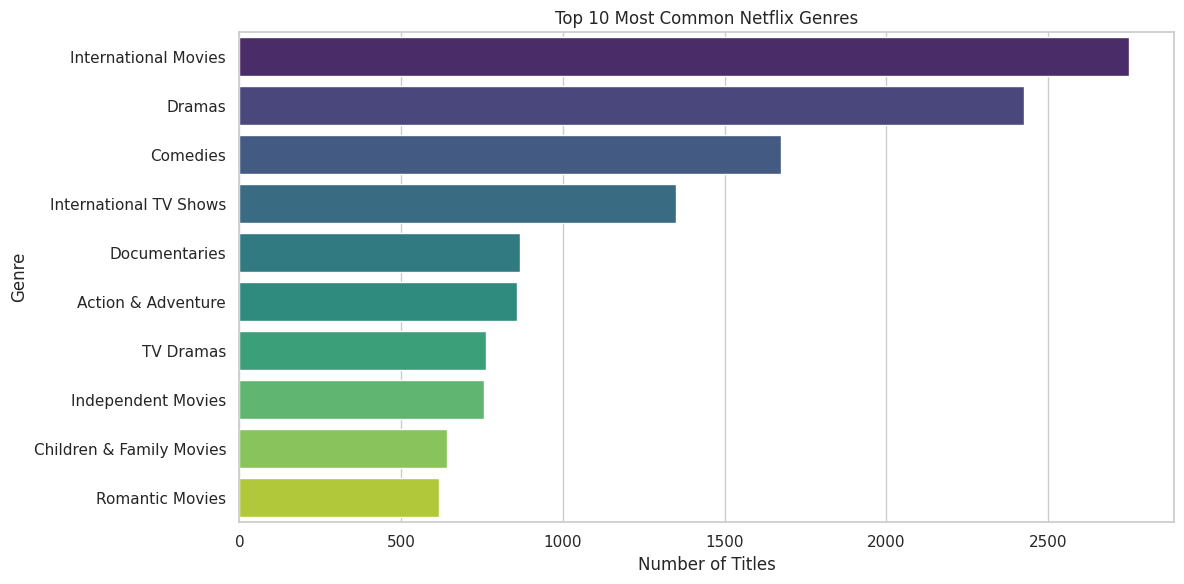

In [24]:
top_genres = (
    title_genre_df
    .groupby('genre_id')
    .size()
    .reset_index(name='count')
    .merge(genre_list, on='genre_id')
    .sort_values('count', ascending=False)
    .head(10)
)

sns.barplot(x='count', y='genre', data=top_genres, palette='viridis')
plt.title("Top 10 Most Common Netflix Genres")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


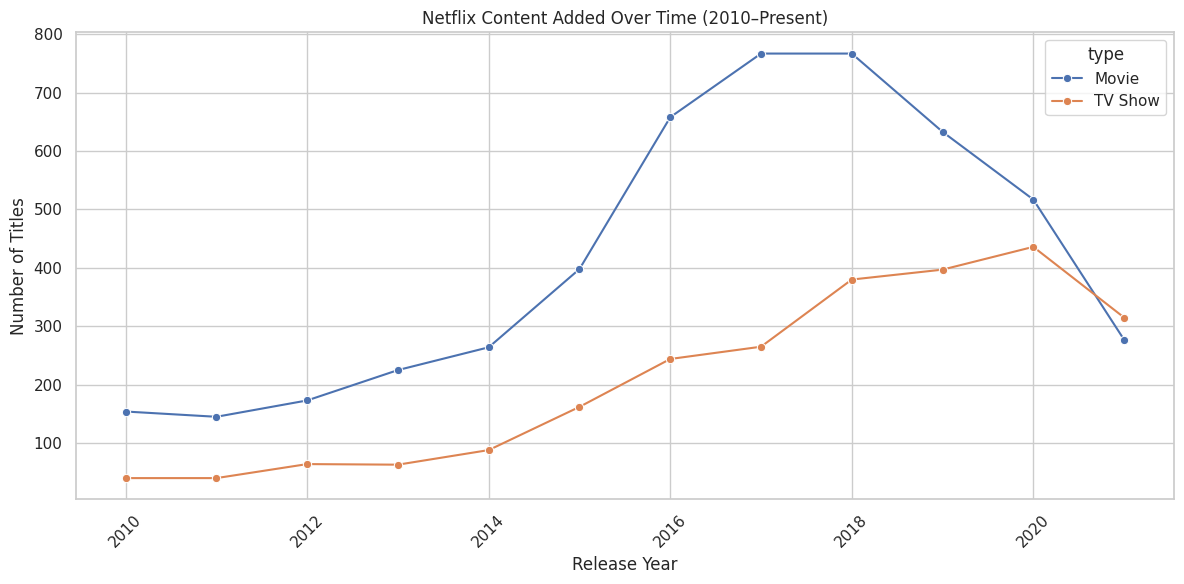

In [25]:
yearly_trend = (
    df[df['release_year'] >= 2010]  # filter to last 15 years
    .groupby(['release_year', 'type'])
    .size()
    .reset_index(name='count')
)

sns.lineplot(x='release_year', y='count', hue='type', data=yearly_trend, marker='o')
plt.title("Netflix Content Added Over Time (2010–Present)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1984371864.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='country', data=top_countries, palette='coolwarm')


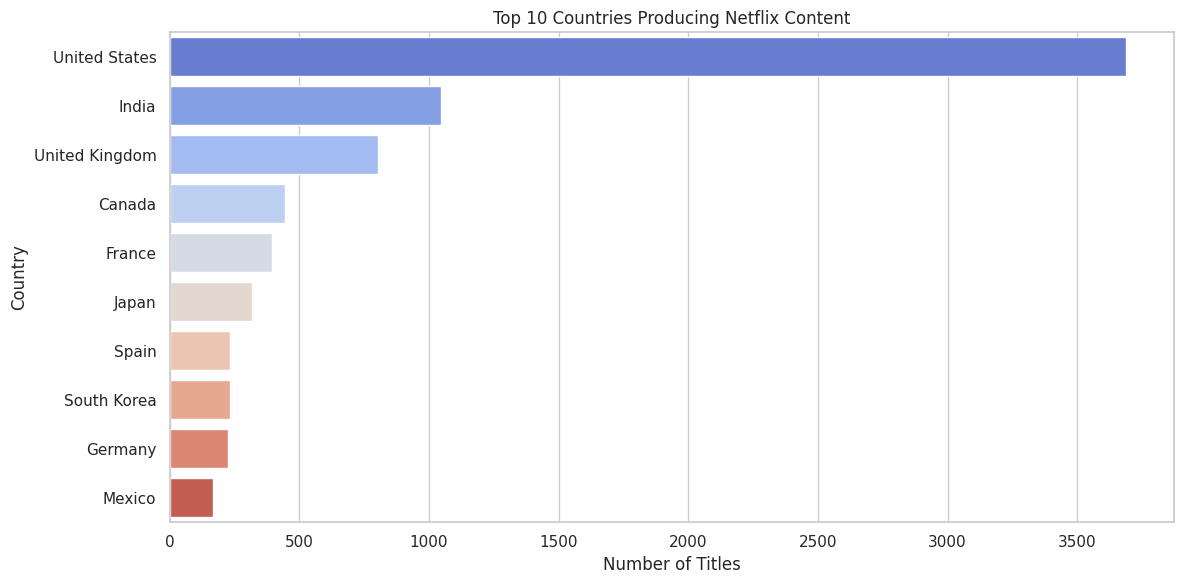

In [26]:
top_countries = (
    df['country']
    .dropna()
    .str.split(', ')
    .explode()
    .value_counts()
    .head(10)
    .reset_index()
)
top_countries.columns = ['country', 'count']

sns.barplot(x='count', y='country', data=top_countries, palette='coolwarm')
plt.title("Top 10 Countries Producing Netflix Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [27]:
plt.savefig('top_genres.png')


<Figure size 1200x600 with 0 Axes>